In [59]:
import scipy.signal as sig
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as lin
import statsmodels.tsa.stattools as stools
import statsmodels.tsa.ar_model as ar
from copy import deepcopy

In [60]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [61]:
N = 10000
alpha = 0.2
w = np.random.randn(N)

We generate a signal as

$$
y[n] = \alpha x[n] + (1-\alpha) y[n-1]
$$

with $w[n]$ being white-noise.

In [62]:
a = [1, alpha-1]
b = [alpha]
x = sig.lfilter(b,a,w)

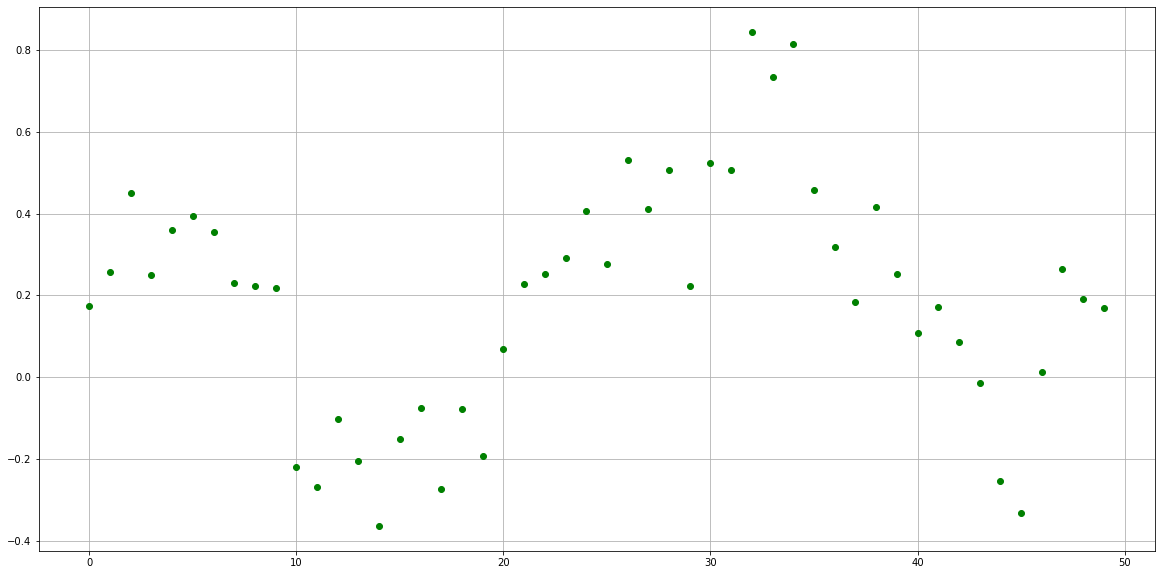

In [63]:
# plt.plot(range(N), w, 'r+', range(N), x, 'go')
plt.plot(range(50), x[0:50], 'go')
plt.grid()

Estimate the ACF of the sequence. This should be equal to $(1-\alpha)^k$

[ 1.          0.79785861  0.63816746  0.50744926  0.39924427  0.31690984
  0.25625742  0.20554149  0.15905245  0.12076134  0.08738611  0.06017293
  0.0404162   0.0287618   0.0205967   0.01027584  0.00466245 -0.00158622
 -0.0048041  -0.01012836 -0.01744128 -0.02519329 -0.02780012 -0.03115128
 -0.02933188 -0.01560627 -0.00486955 -0.00174258  0.00131809  0.00314518
 -0.00122894 -0.00270059 -0.00124105 -0.0035609  -0.00658376 -0.0101167
 -0.01297698 -0.00944142 -0.01160416 -0.01266765 -0.0146677  -0.01979135
 -0.02301095 -0.01555847 -0.01462589 -0.01184901 -0.00953468 -0.00831278
 -0.00292943 -0.00205612  0.00247669]


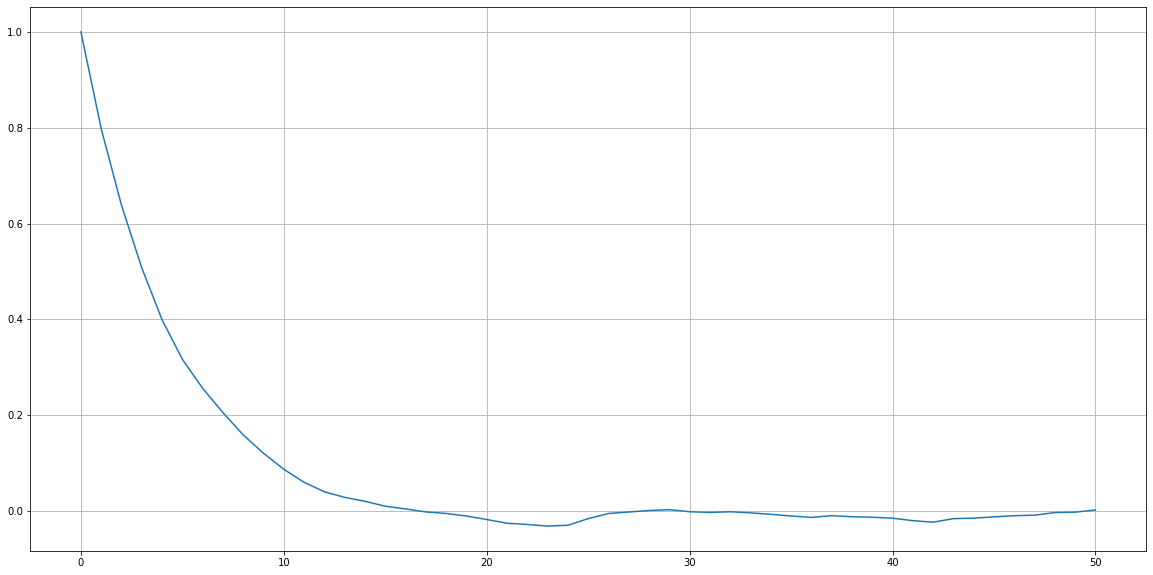

In [64]:
acf=stools.acf(x, nlags=50, fft=False)
print(acf)
plt.plot(acf)
plt.grid()

Now we fit an AR model. For fun, we choose a higher order - AR(3) - and see that only the first coefficient y.L1 is significantly non-zero (check the confidence intervals!) equaling $1 - \alpha$.

In [65]:
mod = ar.AutoReg(x, 3, old_names=False)
res = mod.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                10000
Model:                     AutoReg(3)   Log Likelihood                1920.608
Method:               Conditional MLE   S.D. of innovations              0.200
Date:                Thu, 12 Aug 2021   AIC                             -3.221
Time:                        09:59:44   BIC                             -3.218
Sample:                             3   HQIC                            -3.220
                                10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.002      0.075      0.940      -0.004       0.004
y.L1           0.7944      0.010     79.439      0.000       0.775       0.814
y.L2           0.0112      0.013      0.874      0.3

So far so good. What we next want to do is to predict; i.e. obtain a predicated value for $x[k]$ which we denote as $\hat x[n]$. We restrict ourselves to linear prediction and therefore

$$
\hat x[n] = a_1 x[n-1] + a_2 x[n-2] + \cdots + a_p x[n-p] = \sum_{k=1}^p a_k x[n-k]
$$

Looking at https://en.wikipedia.org/wiki/Linear_prediction, we have so far only estimated model parameters. Out of these we should be able to estimate / calculate the ACF (we have done this above). We stick the ACF into the matrix $R$ and vector $r$ and solve for the filter parameters $a$ by

$$
Ra = r
$$

In [66]:
L = 40
R = lin.toeplitz(acf[0:L])
r = acf[1:L+1]
R, r

(array([[ 1.        ,  0.79785861,  0.63816746, ..., -0.00944142,
         -0.01160416, -0.01266765],
        [ 0.79785861,  1.        ,  0.79785861, ..., -0.01297698,
         -0.00944142, -0.01160416],
        [ 0.63816746,  0.79785861,  1.        , ..., -0.0101167 ,
         -0.01297698, -0.00944142],
        ...,
        [-0.00944142, -0.01297698, -0.0101167 , ...,  1.        ,
          0.79785861,  0.63816746],
        [-0.01160416, -0.00944142, -0.01297698, ...,  0.79785861,
          1.        ,  0.79785861],
        [-0.01266765, -0.01160416, -0.00944142, ...,  0.63816746,
          0.79785861,  1.        ]]),
 array([ 0.79785861,  0.63816746,  0.50744926,  0.39924427,  0.31690984,
         0.25625742,  0.20554149,  0.15905245,  0.12076134,  0.08738611,
         0.06017293,  0.0404162 ,  0.0287618 ,  0.0205967 ,  0.01027584,
         0.00466245, -0.00158622, -0.0048041 , -0.01012836, -0.01744128,
        -0.02519329, -0.02780012, -0.03115128, -0.02933188, -0.01560627,
        

In [67]:
apred=lin.solve(R,r)
apred

array([ 7.93934821e-01,  1.20313128e-02,  4.74336552e-04, -1.79654171e-02,
       -1.99417189e-03,  1.61792084e-02,  8.21808095e-03, -1.11043511e-02,
        2.34706777e-03, -5.38319838e-03, -6.93316026e-03, -6.33295129e-03,
        6.79304803e-03,  1.14054398e-02, -1.52659188e-02,  8.58784269e-03,
       -7.57738630e-03,  9.81033756e-03, -9.75535175e-04, -3.63515814e-03,
       -1.28997507e-02,  9.97557475e-03, -1.43193044e-02, -1.71520140e-02,
        2.76919576e-02,  1.28242543e-02, -1.29215751e-02,  1.80104828e-03,
        1.21700051e-02, -1.62347615e-02, -1.87832076e-03,  1.21486616e-02,
       -4.47437961e-03, -1.16248140e-03, -4.16290001e-03, -1.33642615e-02,
        2.55638059e-02, -1.24919076e-02,  2.42990912e-03, -4.89908398e-03])

Now we perform the prediction. Careful, the output of the FIR filter at time $n$ is the prediction for time $n+1$, so we have to insert a $0$ at the beginning.

In [68]:
xpred=sig.lfilter(apred,[1], x)
xpred_shifted = np.zeros(N+1)
xpred_shifted[1:N+1] = xpred

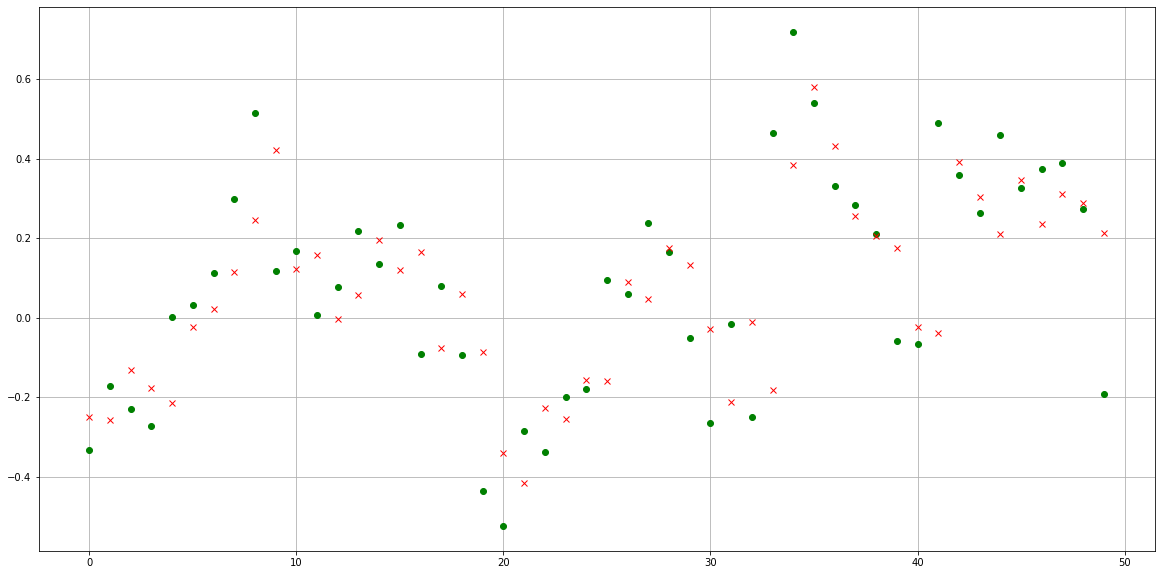

In [69]:
strt = 100
plt.plot(range(50), x[strt:strt+50], 'go', range(50), xpred_shifted[strt:strt+50], 'rx')
plt.grid()

Above plot looks ok, but performance is difficult to judge. Let's calculate the MSE for some objective numbers...

First we calculate the MSE of the predictor.

Some values from runs with different values for alpha; higher alpha causes higher error.

alpha = 0.05 => 8.75e-05
alpha = 0.1 => 0.000249
alpha = 0.2 => 0.00068

In [70]:
lin.norm(xpred - x) / N

0.0006803486175117257

And now we use a completely random sequence for prediction and compare the MSE. There is quite a difference!

In [71]:
pred_rand = np.random.randn(N)
lin.norm(pred_rand - x) / N

0.01053314226082401

Just for fun... If we subtract two random RVs from each other, their mean squared diff = 2

In [74]:
w1 = np.random.randn(N)
w2 = np.random.randn(N)
( lin.norm(w1 - w2)**2 / N, lin.norm(w1 - w2)**2 / N)

(2.0313454946113287, 2.0313454946113287)